In [ ]:
import pandas as pd
import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from nltk.corpus import wordnet
import random
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
import nltk

In [ ]:
DATA_PATH = "lai-data/political_leaning.csv"
FEATURE = "political_leaning"

In [ ]:
df_politics = pd.read_csv(DATA_PATH).iloc[:3000] # remove iloc to test full dataset

In [ ]:
df_politics

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_politics['post'], df_politics[FEATURE],test_size= 0.3)

In [ ]:
nlp = spacy.load("en_core_web_sm")

## 1. BoW SVC model

In [ ]:
clf = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('svc', LinearSVC())
])

In [8]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

      center       0.73      0.75      0.74      7559
        left       0.67      0.66      0.66      4367
       right       0.71      0.70      0.70      5244

    accuracy                           0.71     17170
   macro avg       0.70      0.70      0.70     17170
weighted avg       0.71      0.71      0.71     17170



## 2. BoW SVC with EDA
### 2.1 Data augmentation

In [9]:
nltk.download('wordnet')

class SynonymReplacementTransformer(TransformerMixin):
    def __init__(self, p=0.2):
        self.p = p

    def synonym_replacement(self, sentence):
        words = sentence.split()

        self.n = int(self.p * len(sentence))
        for _ in range(self.n):
            idx = random.randint(0, len(words) - 1)
            word = words[idx]
            synonyms = [syn.name() for syn in wordnet.synsets(word)]
            if synonyms:
                replacement = random.choice(synonyms)
                words[idx] = replacement
        return ' '.join(words)

    def transform(self, X, y=None):
        return [self.synonym_replacement(sentence) for sentence in X]
    
class RandomInsertionTransformer(TransformerMixin):
    def __init__(self, p=0.2):
        self.p = p

    def random_insertion(self, sentence):
        words = sentence.split()
        self.n = int(self.p * len(sentence))
        for _ in range(self.n):
            idx = random.randint(0, len(words) - 1)
            word = words[idx]
            
            # Get synonyms of the word that are not stop words
            synonyms = [syn.name() for syn in wordnet.synsets(word) if syn.name() not in nltk.corpus.stopwords.words('english')]
            
            if synonyms:
                synonym = random.choice(synonyms)
                words.insert(random.randint(0, len(words)), synonym)
        return ' '.join(words)

    def transform(self, X, y=None):
        return [self.random_insertion(sentence) for sentence in X]

class RandomSwapTransformer(TransformerMixin):
    def __init__(self, p=0.2):
        self.p = p

    def random_swap(self, sentence):
        words = sentence.split()
        self.n = int(self.p * len(sentence))
        for _ in range(self.n):
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]
        return ' '.join(words)

    def transform(self, X, y=None):
        return [self.random_swap(sentence) for sentence in X]

class RandomDeletionTransformer(TransformerMixin):
    def __init__(self, p=0.2):
        self.p = p

    def random_deletion(self, sentence):
        words = sentence.split()
        words = [word for word in words if random.uniform(0, 1) > self.p]
        return ' '.join(words)

    def transform(self, X, y=None):
        return [self.random_deletion(sentence) for sentence in X]

[nltk_data] Downloading package wordnet to /home/egor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# p - % of the sentence to be augmented (good values - 1%, 2%, 5%, 10%, 20%)

synonym_replacement_transformer = SynonymReplacementTransformer(p=0.2)
random_insertion_transformer = RandomInsertionTransformer(p=0.2)
random_swap_transformer = RandomSwapTransformer(p=0.2)
random_deletion_transformer = RandomDeletionTransformer(p=0.2)

In [11]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

n_aug = 4 # The number of augmented instances of a sentence (good values - 2, 4, 8, 16)

X_train_augmented = []
y_train_augmented = []
for sentence, label in tqdm(zip(X_train, y_train)):
    # augmented_sentences = [sentence]  # Keep the original sentence
    augmented_sentences = []
    sentence = ' '.join([word for word in sentence.split() if word.lower() not in stop_words])

    for _ in range(n_aug):
        chosen_operation = random.choice(['SR', 'RI' 'RS', 'RD'])  

        if chosen_operation == 'SR':
            augmented_sentences.append(synonym_replacement_transformer.transform([sentence])[0])
        elif chosen_operation == 'RI':
            # augmented_sentences.append(random_insertion_transformer.transform([sentence])[0]) # Insertions take too long
            augmented_sentences.append(sentence)
        elif chosen_operation == 'RS':
            augmented_sentences.append(random_swap_transformer.transform([sentence])[0])
        elif chosen_operation == 'RD':
            augmented_sentences.append(random_deletion_transformer.transform([sentence])[0])

    X_train_augmented.extend(augmented_sentences)
    y_train_augmented.extend([label] * len(augmented_sentences))


### 2.2 BoW SVC with EDA model training and evaluation

In [12]:
# Your pipeline with data augmentation
clfEDA = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('svc', LinearSVC())
])

# Fit the model with augmented data
clfEDA.fit(X_train_augmented, y_train_augmented)

In [13]:
y_pred = clfEDA.predict(X_test)
print(classification_report(y_test, y_pred))

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
import string
import emoji


# Custom transformer for stylometry feature extraction
class StylometryFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        stylometry_features = []
        for text in X:
            # Tokenize sentences and words
            sentences = [word_tokenize(sentence) for sentence in sent_tokenize(text)]
            words = [word for sentence in sentences for word in sentence]

            # Basic stylometry features
            features = {
                'sentence_count': len(sentences),
                'word_count': len(words),
                'avg_sentence_length': len(words) / len(sentences) if len(sentences) > 0 else 0,
                'avg_word_length': sum(len(word) for word in words) / len(words) if len(words) > 0 else 0,
                'num_punctuation': sum(1 for char in text if char in string.punctuation),
                'num_uppercase': sum(1 for char in text if char.isupper()),
                'num_digits': sum(1 for char in text if char.isdigit()),
                'num_emojis': len([char for char in text if char in emoji.EMOJI_DATA])
            }

            stylometry_features.append(features)

        return pd.DataFrame(stylometry_features)

In [64]:
# Create a pipeline
clf_stylometry = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer()),  # You can include other text-based features here
        ('stylometry', StylometryFeatureExtractor())
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LinearSVC())
])

In [65]:
# Fit the model
clf_stylometry.fit(X_train, y_train)

/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text', CountVectorizer()),
                                                ('stylometry',
                                                 StylometryFeatureExtractor())])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', LinearSVC())])

In [66]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

def evaluate_clf(clf, X, y_true, classes, normalize=True, cmap=plt.cm.Blues):
    y_pred = clf.predict(X)
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

In [67]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

TARGET_COL = 'political_leaning'
INDEPENDENT_COL = 'post'

def label_encode(df, col_name):
    label_encoder = LabelEncoder()
    df[col_name] = label_encoder.fit_transform(df[col_name])
    return df, label_encoder


df, le = label_encode(df_politics, TARGET_COL)

              precision    recall  f1-score   support

      center       0.73      0.82      0.78      7559
        left       0.77      0.63      0.69      4367
       right       0.76      0.74      0.75      5244

    accuracy                           0.75     17170
   macro avg       0.75      0.73      0.74     17170
weighted avg       0.75      0.75      0.75     17170



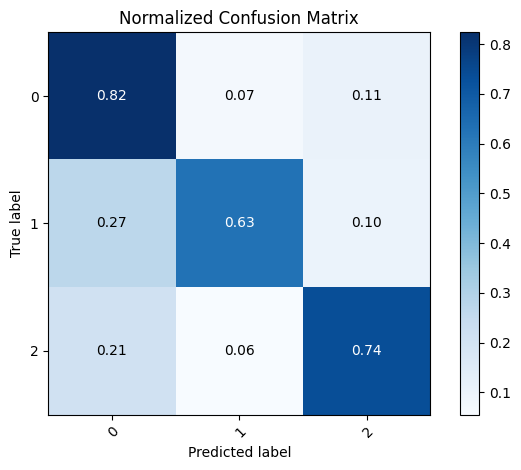

In [68]:
evaluate_clf(clf_stylometry, X_test, y_test, classes=le.classes_)

In [47]:
df_politics

,auhtor_ID,post,political_leaning
0,t2_7ramzeng,"You can ""buy"" the show and stream it through t...",2
1,t2_7ramzeng,"me want to play Q*bert Holy shit, based Alex J...",2
2,t2_7ramzeng,Shouldn't rely on any external services or per...,2
3,t2_7ramzeng,PR to a specific person. Usually that just mea...,2
4,t2_7ramzeng,This article's intention is clear that they wa...,2
...,...,...,...
57226,t2_4ngvl16j,a good one? That's odd. I remember it as being...,0
57227,t2_4ngvl16j,"boring shit in the fucking world. ""History doe...",0
57228,t2_4ngvl16j,you see no contradiction there? Why or why not...,0
57229,t2_4ngvl16j,is only created by an incommensurate worldview...,0


In [22]:
# Create a pipeline
clf_pure_stylometry = Pipeline([
    ('features', FeatureUnion([
        ('stylometry', StylometryFeatureExtractor())
    ])),
    ('scaler', StandardScaler(with_mean=False)),
    ('clf', LinearSVC())
])

In [23]:
clf_pure_stylometry.fit(X_train, y_train)

/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/egor/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('stylometry',
                                                 StylometryFeatureExtractor())])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', LinearSVC())])

              precision    recall  f1-score   support

      center       0.44      0.74      0.55      7559
        left       0.33      0.14      0.20      4367
       right       0.36      0.19      0.25      5244

    accuracy                           0.42     17170
   macro avg       0.38      0.36      0.33     17170
weighted avg       0.39      0.42      0.37     17170



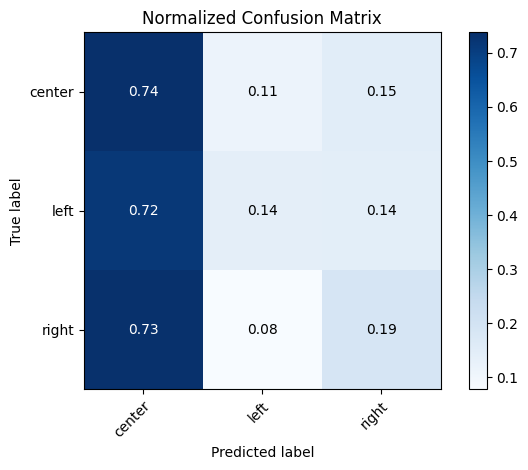

In [24]:
evaluate_clf(clf_pure_stylometry, X_test, y_test, classes=le.classes_)

<Axes: >

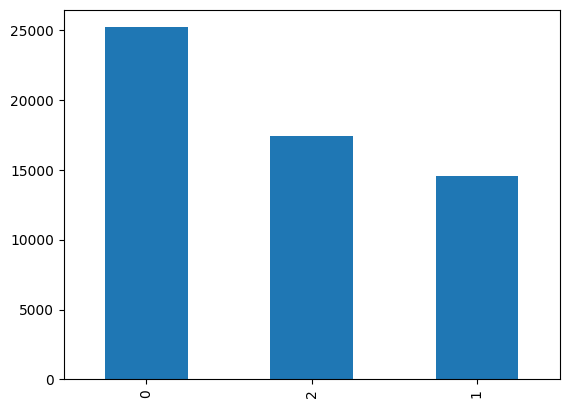

In [25]:
df_politics['political_leaning'].value_counts().plot(kind='bar')

In [26]:
sum(df_politics['political_leaning'] == 0) / len(df_politics)

0.44033827820586746